# Analysing Telco Company's Customer Churn Rate

- The goal of this project is to analyse the customer base of the given telco company and to predict the probability of churn.

- The dataset was created by IBM and contains information about services provided to 7043 customers in California in Q3. A more detailed description is available on [IBM's website](https://community.ibm.com/community/user/blogs/steven-macko/2019/07/11/telco-customer-churn-1113).


The original dataset is provided by IBM in XLSX format. For the purpose of a more realistic analysis environment, the data has been moved into a PostgreSQL database inside a Docker container. The data entries were uploaded using pdAdmin. The schema is described in `schema.sql`.

### Connecting to the database

In [179]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [56]:
%load_ext sql

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [57]:
user = 'postgres'
password = 'password'
host = '127.0.0.1'
port = 5431
database = 'telco-db'

connection_string = f"postgresql://{user}:{password}@{host}:{port}/{database}"

%sql $connection_string

%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

In [58]:
%%sql
SELECT table_name AS "Table Name"
FROM information_schema.tables
WHERE table_schema NOT IN ('pg_catalog', 'information_schema')

Table Name
local_population
demographics
location
services
status


## Database overview

### `location` table

In [59]:
%%sql
SELECT *
FROM location
LIMIT 5

location_id,customer_id,count,country,state,city,zip_code,lat_long,latitude,longitude
OXCZEW7397,8779-QRDMV,1,United States,California,Los Angeles,90022,"34.02381, -118.156582",34.02381,-118.156582
FCCECI8494,7495-OOKFY,1,United States,California,Los Angeles,90063,"34.044271, -118.185237",34.044271,-118.185237
HEHUQY7254,1658-BYGOY,1,United States,California,Los Angeles,90065,"34.108833, -118.229715",34.108833,-118.229715
WIUHRF2613,4598-XLKNJ,1,United States,California,Inglewood,90303,"33.936291, -118.332639",33.936291,-118.332639
CFEZBF4415,4846-WHAFZ,1,United States,California,Whittier,90602,"33.972119, -118.020188",33.972119,-118.020188


This table contains location details of customers that are all based in California. The primary key of this table is composite and made up of `location_id` and `customer_id`.

### `services` table

In [60]:
%%sql
SELECT *
FROM services
LIMIT 5

service_id,customer_id,count,quarter,referred_a_friend,n_referred,months_tenure,offer,phone_service,avg_monthly_long_dist_charge,multiple_lines,internet_service,internet_type,avg_monthly_gb_down,online_security,online_backup,device_protection,premium_tech_support,streaming_tv,streaming_movies,streaming_music,unlimited_data,contract_type,paperless_billing,payment_method,monthly_charge,total_charge,total_refunds,total_extra_data_charges,total_long_dist_charges,total_revenue
IJKDQVSWH3522,8779-QRDMV,1,Q3,No,0,1,None,No,0.0,No,Yes,DSL,8,No,No,Yes,No,No,Yes,No,No,Month-to-Month,Yes,Bank Withdrawal,39.65,39.65,0.0,20.0,0.0,59.65
BFKMZJAIE2285,7495-OOKFY,1,Q3,Yes,1,8,Offer E,Yes,48.85,Yes,Yes,Fiber Optic,17,No,Yes,No,No,No,No,No,Yes,Month-to-Month,Yes,Credit Card,80.65,633.3,0.0,0.0,390.8,1024.1
EIMVJQBMT7187,1658-BYGOY,1,Q3,No,0,18,Offer D,Yes,11.33,Yes,Yes,Fiber Optic,52,No,No,No,No,Yes,Yes,Yes,Yes,Month-to-Month,Yes,Bank Withdrawal,95.45,1752.55,45.61,0.0,203.94,1910.88
EROZQXDUU4979,4598-XLKNJ,1,Q3,Yes,1,25,Offer C,Yes,19.76,No,Yes,Fiber Optic,12,No,Yes,Yes,No,Yes,Yes,No,Yes,Month-to-Month,Yes,Bank Withdrawal,98.5,2514.5,13.43,0.0,494.0,2995.07
GEEYSJUHY6991,4846-WHAFZ,1,Q3,Yes,1,37,Offer C,Yes,6.33,Yes,Yes,Fiber Optic,14,No,No,No,No,No,No,No,Yes,Month-to-Month,Yes,Bank Withdrawal,76.5,2868.15,0.0,0.0,234.21,3102.36


In [61]:
%%sql
SELECT column_name AS "Column Name"
FROM information_schema.columns
WHERE table_catalog = 'telco-db' AND table_name = 'services'
ORDER BY ordinal_position

Column Name
service_id
customer_id
count
quarter
referred_a_friend
n_referred
months_tenure
offer
phone_service
avg_monthly_long_dist_charge


This table contains client-specific information about the service provided and the main information that will be useful when modelling churn.

### `status` table

In [62]:
%%sql
SELECT *
FROM status
LIMIT 5

status_id,customer_id,count,quarter,satisfaction_score,customer_status,churn_label,churn_value,church_score,cltv,churn_category,churn_reason
SWSORB1252,8779-QRDMV,1,Q3,3,Churned,Yes,True,91,5433,Competitor,Competitor offered more data
SNAEQA8572,7495-OOKFY,1,Q3,3,Churned,Yes,True,69,5302,Competitor,Competitor made better offer
LMBQNN3714,1658-BYGOY,1,Q3,2,Churned,Yes,True,81,3179,Competitor,Competitor made better offer
VRZYZI9978,4598-XLKNJ,1,Q3,2,Churned,Yes,True,88,5337,Dissatisfaction,Limited range of services
FDNAKX1688,4846-WHAFZ,1,Q3,2,Churned,Yes,True,67,2793,Price,Extra data charges


This table shows information regarding the currect customer's satisfaction and whether they have or have not churned. Information about the cause of churn is also provided along with customer lifetime value which can also be modelled.

### `local_population` table

In [63]:
%%sql
SELECT *
FROM local_population
LIMIT 5

id,zip_code,population
1,90001,54492
2,90002,44586
3,90003,58198
4,90004,67852
5,90005,43019


This table shows the local population in a given zip code. This can be used to discert more urban areas from more rural ones.

### `demographics` table

In [64]:
%%sql
SELECT *
FROM demographics
LIMIT 5

customer_id,count,gender,age,under_30,is_senior,is_married,has_dependents,n_dependents
8779-QRDMV,1,Male,78,No,Yes,No,No,0
7495-OOKFY,1,Female,74,No,Yes,Yes,Yes,1
1658-BYGOY,1,Male,71,No,Yes,No,Yes,3
4598-XLKNJ,1,Female,78,No,Yes,Yes,Yes,1
4846-WHAFZ,1,Female,80,No,Yes,Yes,Yes,1


This table describes the person's demographic details such as age, gender and family status.

## Exploring the data

One way to analyse this data would be merging all tables and performing analysys on Pandas's DataFrame but let's instead perform basic analysis through SQL itself.

#### What is our typical customer?

In [186]:
%%sql
WITH genderTable AS (
    SELECT gender,
        COUNT(*) AS count
    FROM demographics
    GROUP BY gender
    ORDER BY count DESC
    LIMIT 1
),
ageTable AS (
    SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY age) AS median
    FROM demographics
),
marriedTable AS (
    SELECT is_married,
        COUNT(*) AS count
    FROM demographics
    GROUP BY is_married
    ORDER BY count DESC
    LIMIT 1
),
dependentsTable AS (
    SELECT PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY n_dependents) AS median
    FROM demographics
)
SELECT 
    genderTable.gender AS most_common_gender,
    ageTable.median AS median_age,
    marriedTable.is_married AS most_common_marital_status,
    dependentsTable.median AS median_dependents
FROM genderTable
CROSS JOIN ageTable
CROSS JOIN marriedTable
CROSS JOIN dependentsTable;

most_common_gender,median_age,most_common_marital_status,median_dependents
Male,46.0,No,0.0


We should expect that our *average* is a 46 year-old, usually male, that is not married and has no children.

#### How long have our customers been with the company?

In [65]:
%%sql
SELECT churn_value AS churned,
       MIN(months_tenure),
       PERCENTILE_CONT(0.25) WITHIN GROUP (
          ORDER BY months_tenure) AS q25,
       PERCENTILE_CONT(0.5) WITHIN GROUP (
          ORDER BY months_tenure) AS median,
       AVG(months_tenure),
       PERCENTILE_CONT(0.75) WITHIN GROUP (
          ORDER BY months_tenure) AS q75,
       MAX(months_tenure)
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value

churned,min,q25,median,avg,q75,max
False,1,15.0,38.0,37.5912253575570158,61.0,72
True,1,2.0,10.0,17.9791332263242376,29.0,72


The data shows us that churned customers churn earlier than those that have stayed - Q75 for churned customers is well below the median for the non-churned ones. We have clear separation. That is positive news as it means that our loyal customers are choosing to stay.

#### How many customers have churned?

In [123]:
%%sql
SELECT ROUND((SELECT COUNT(*)
              FROM status
              WHERE churn_value = True) / CAST(COUNT(*) AS numeric) * 100, 2) AS percentage_churned,
       (SELECT COUNT(*)
              FROM status
              WHERE churn_value = True) AS number_churned
FROM status

percentage_churned,number_churned
26.54,1869


We have lost almost 1/3 of our customers. Since the data is provided only for Q3, it is hard to put this number into perspective.

#### What causes churn?

In [67]:
%%sql
SELECT churn_category, churn_reason, COUNT(*)
FROM status
WHERE churn_value = True
GROUP BY churn_category, churn_reason
ORDER BY churn_category, churn_reason

churn_category,churn_reason,count
Attitude,Attitude of service provider,94
Attitude,Attitude of support person,220
Competitor,Competitor had better devices,313
Competitor,Competitor made better offer,311
Competitor,Competitor offered higher download speeds,100
Competitor,Competitor offered more data,117
Dissatisfaction,Lack of self-service on Website,29
Dissatisfaction,Limited range of services,37
Dissatisfaction,Network reliability,72
Dissatisfaction,Poor expertise of online support,13


The biggest cause of churn seems to be the lack of competitiveness of our company in the market. According to the customers, other companies either offer more data or their connection is faster. This might indicate that more market research needs to be done in order to investigate what offers or changes would be most attractive to potencial and current clients.

We also may potencially have an issue with our client support team. We should investigate individual cases where the client was dissatisfied. Maybe the wait time was too long or the support specialist may have been unpleasent, or even our customer might not feel valued.

Churn reason 'Don't know' should be turned into meaningful values by contacting the clients as these values may hide extreme cases of dissatisfaction where the client might have been so fed up that they didn't even bother to respond.

#### Do churned customers pay more?

In [68]:
%%sql
SELECT churn_value AS churned,
       ROUND(CAST(AVG(monthly_charge) AS numeric), 2) AS montly_charge,
       ROUND(CAST(STDDEV(monthly_charge) AS numeric), 2) AS montly_charge_sd
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value

churned,montly_charge,montly_charge_sd
False,61.27,31.09
True,74.44,24.67


Churned customers were, in fact, paying more on average. The distributions are most likely overlapping.

That begs the question: are offering worse deals to the customers that are not satisfied with the company?

In [69]:
%%sql churn_count_charge <<
SELECT churn_value, offer,
       COUNT(offer), ROUND(CAST(AVG(monthly_charge) AS numeric), 2) AS avg_monthly_charge,
       ROUND(CAST(STDDEV(monthly_charge) AS numeric), 2) AS montly_charge_sd
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value, offer
ORDER BY churn_value, offer

Returning data to local variable churn_count_charge


In [70]:
churn_count_charge

churn_value,offer,count,avg_monthly_charge,montly_charge_sd
False,None,2826,60.27,30.96
False,Offer A,485,76.11,31.40
False,Offer B,723,68.52,31.09
False,Offer C,320,61.16,29.80
False,Offer D,441,51.30,27.62
False,Offer E,379,47.50,24.99
True,None,1051,75.33,23.95
True,Offer A,35,99.97,14.06
True,Offer B,101,87.36,23.26
True,Offer C,95,84.84,18.77


It is difficult to read a table with multiple conditions so let's plot the data.

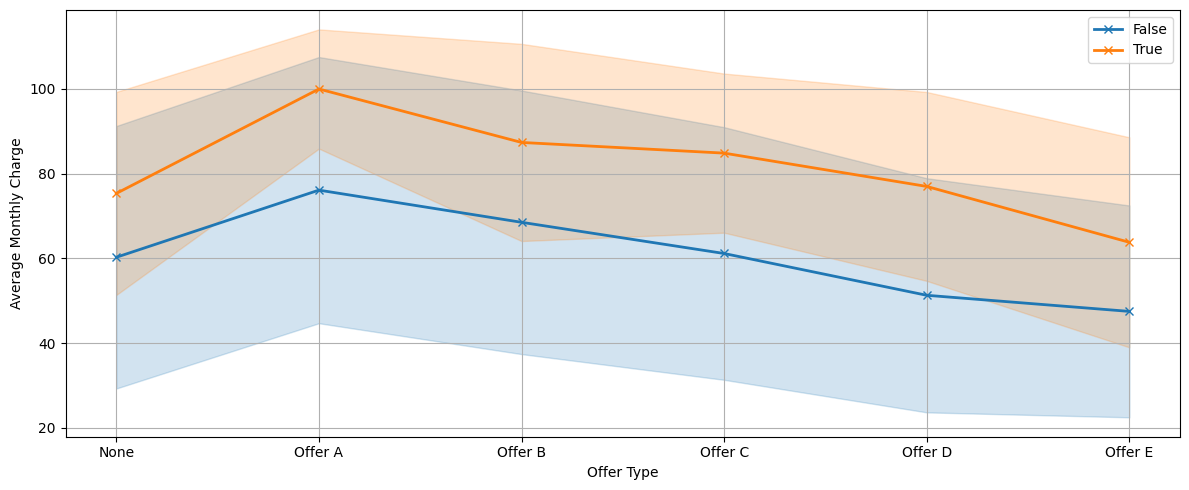

In [71]:
df = churn_count_charge.DataFrame()

fig, ax = plt.subplots(figsize=(12, 5))

for churn_val, group in df.groupby("churn_value"):

    line = ax.plot(group["offer"], group["avg_monthly_charge"], 
                   marker='x', linewidth=2, markersize=6, 
                   label=f"{churn_val}")
    
    color = line[0].get_color()
    
    ax.fill_between(group["offer"], 
                    group["avg_monthly_charge"] - group["montly_charge_sd"],
                    group["avg_monthly_charge"] + group["montly_charge_sd"],
                    alpha=0.2, color=color)

ax.set_xlabel("Offer Type")
ax.set_ylabel("Average Monthly Charge")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()

One thing is clear - we are overcharging some of our customers and, in turn, they choosing to go elsewhere.

#### Does the churn rate change with tenure?

In [72]:
%%sql churn_tenure <<
SELECT COUNT(*), churn_value,
CASE
    WHEN months_tenure < 3 THEN '0-3'
    WHEN months_tenure BETWEEN 3 AND 9 THEN '3-9'
    WHEN months_tenure BETWEEN 9 AND 12 THEN '9-12'
    WHEN months_tenure BETWEEN 12 AND 24 THEN '12-24'
    ELSE '24+'
END AS tenure_category
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY tenure_category, churn_value
ORDER BY tenure_category, churn_value

Returning data to local variable churn_tenure


In [73]:
churn_tenure

count,churn_value,tenure_category
348,False,0-3
503,True,0-3
730,False,12-24
294,True,12-24
3295,False,24+
538,True,24+
572,False,3-9
420,True,3-9
229,False,9-12
114,True,9-12


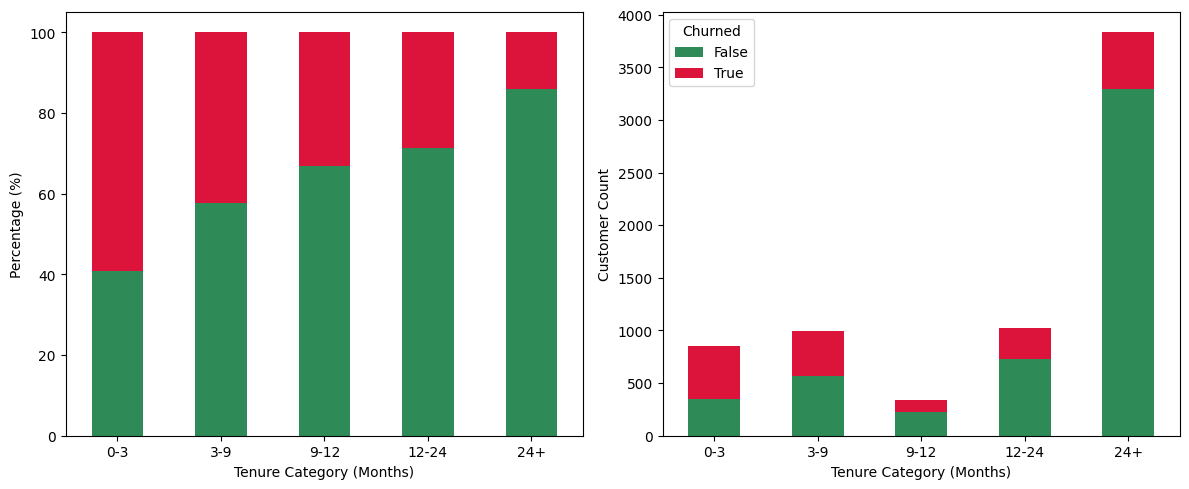

In [74]:
churn_tenure = pd.DataFrame(churn_tenure)

tenure_order = ["0-3", "3-9", "9-12", "12-24", "24+"]

churn_tenure["tenure_category"] = pd.Categorical(churn_tenure["tenure_category"], categories=tenure_order, ordered=True)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = axes[0]
pivot_df_pct = churn_tenure.pivot(index="tenure_category", columns="churn_value", values="count")
pivot_df_pct = pivot_df_pct.reindex(tenure_order)
pivot_df_pct = pivot_df_pct.div(pivot_df_pct.sum(axis=1), axis=0) * 100
pivot_df_pct.plot(kind="bar", stacked=True, ax=ax1, color=["#2E8B57", "#DC143C"])
ax1.set_xlabel("Tenure Category (Months)")
ax1.set_ylabel("Percentage (%)")
ax1.tick_params(axis="x", rotation=0)
ax1.get_legend().remove()

ax2 = axes[1]
pivot_df = churn_tenure.pivot(index="tenure_category", columns="churn_value", values="count")
pivot_df = pivot_df.reindex(tenure_order)
pivot_df.plot(kind="bar", stacked=True, ax=ax2, color=["#2E8B57", "#DC143C"])
ax2.set_xlabel("Tenure Category (Months)")
ax2.set_ylabel("Customer Count")
ax2.tick_params(axis="x", rotation=0)
ax2.legend(title='Churned')

plt.tight_layout()
plt.show()

As it turns out, we are loosing the clients that have been with the company the shortest, especially those in the 0 to 3 month tenure range. This could be a sign that special offers should be used to incentivise new clients to stay. It is also possible that our service is not up to standarts and we should improve the services that we offer. It could also be that these new clients were signed up with a promotion and they decided not to say. We should investigate further by matching tenure categories with reasons for churn.

In [75]:
%%sql tenure_churn_reason <<
SELECT COUNT(*), churn_category,
CASE
    WHEN months_tenure < 3 THEN '0-3'
    WHEN months_tenure BETWEEN 3 AND 9 THEN '3-9'
    WHEN months_tenure BETWEEN 9 AND 12 THEN '9-12'
    WHEN months_tenure BETWEEN 12 AND 24 THEN '12-24'
    ELSE '24+'
END AS tenure_category
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
WHERE churn_value = True
GROUP BY tenure_category, churn_category

Returning data to local variable tenure_churn_reason


In [76]:
tenure_churn_reason

count,churn_category,tenure_category
40,Other,3-9
20,Attitude,9-12
71,Price,24+
86,Dissatisfaction,24+
65,Other,24+
230,Competitor,24+
40,Price,3-9
68,Dissatisfaction,3-9
59,Competitor,9-12
76,Dissatisfaction,0-3


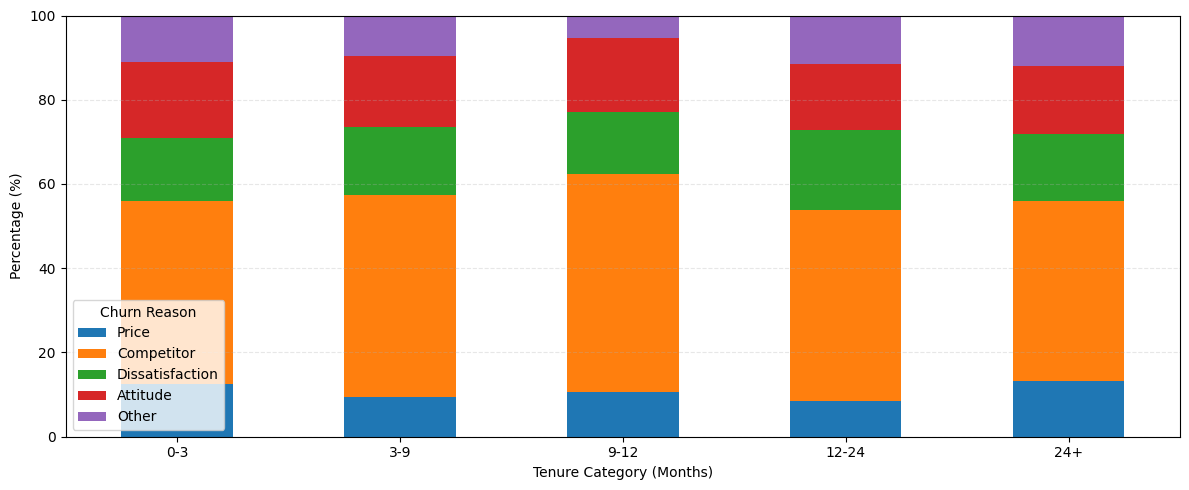

In [113]:
tenure_churn_reason = pd.DataFrame(tenure_churn_reason)

churn_reason_order = ['Price', 'Competitor', 'Dissatisfaction', 'Attitude', 'Other']

tenure_churn_reason['tenure_category'] = pd.Categorical(tenure_churn_reason['tenure_category'],
                                                        categories=tenure_order,
                                                        ordered=True)
tenure_churn_reason['churn_category'] = pd.Categorical(tenure_churn_reason['churn_category'],
                                                       categories=churn_reason_order,
                                                       ordered=True)

fig, ax = plt.subplots(figsize=(12, 5))

pivot_pct = tenure_churn_reason.pivot_table(index='tenure_category',
                                            columns='churn_category',
                                            values='count',
                                            aggfunc='sum',
                                            fill_value=0,
                                            observed=False)

pivot_pct = pivot_pct.reindex(index=tenure_order, columns=churn_reason_order)

pivot_pct_norm = pivot_pct.div(pivot_pct.sum(axis=1), axis=0) * 100

pivot_pct_norm.plot(kind='bar', stacked=True, ax=ax)
ax.set_xlabel('Tenure Category (Months)')
ax.set_ylabel('Percentage (%)')
ax.tick_params(axis='x', rotation=0)
ax.set_ylim(0, 100)
ax.legend(title='Churn Reason')
ax.grid(axis="y", alpha=0.3, linestyle="--")


plt.tight_layout()
plt.show()

We see that churn reasons with regard to tenure categories are distributed around the same. A slightly higher number of customers in the 9 to 12 month category that churned due to 'Competitor' could be attributed to randomness.

#### What types of services are most common?

In [78]:
%%sql
SELECT COUNT(*) as total_combinations
FROM
    (
        SELECT
            phone_service,
            unlimited_data,
            internet_service,
            online_security,
            online_backup,
            device_protection,
            premium_tech_support,
            streaming_tv,
            streaming_movies,
            streaming_music
        FROM
            status
            LEFT JOIN services ON status.customer_id = services.customer_id
        WHERE
            churn_value = True
        GROUP BY
            phone_service,
            unlimited_data,
            internet_service,
            online_security,
            online_backup,
            device_protection,
            premium_tech_support,
            streaming_tv,
            streaming_movies,
            streaming_music
    )

total_combinations
232


There is a total of 232 possible combinations of services that our company offers. Let's take a look at only the core - phone, internet and streaming services.

In [79]:
%%sql
SELECT phone_service,
        internet_service,
        CASE
            WHEN streaming_tv = 'Yes' OR streaming_movies = 'Yes' OR streaming_music = 'Yes' THEN 'Yes'
            ELSE 'No'
        END AS streaming_service,
        COUNT(*)
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
WHERE churn_value = True
GROUP BY phone_service,
         internet_service,
         streaming_service

phone_service,internet_service,streaming_service,count
Yes,No,No,113
No,Yes,Yes,98
Yes,Yes,Yes,1027
No,Yes,No,72
Yes,Yes,No,559


The vast majory of our clients have all three services. Here, `streaming_service` indicates at least one active streaming service (tv, movies, music).

#### What services correlate with churn?

In [105]:
%%sql churn_reason_by_service <<
SELECT churn_category,
        count,
        CASE
            WHEN phone_service = 'Yes' AND internet_service = 'Yes' AND streaming_service = 'Yes' 
                THEN 'Phone + Internet + Streaming'
            WHEN phone_service = 'Yes' AND internet_service = 'Yes' AND streaming_service = 'No' 
                THEN 'Phone + Internet'
            WHEN phone_service = 'Yes' AND internet_service = 'No' AND streaming_service = 'Yes' 
                THEN 'Phone + Streaming'
            WHEN phone_service = 'No' AND internet_service = 'Yes' AND streaming_service = 'Yes' 
                THEN 'Internet + Streaming'
            WHEN phone_service = 'Yes' AND internet_service = 'No' AND streaming_service = 'No' 
                THEN 'Phone Only'
            WHEN phone_service = 'No' AND internet_service = 'Yes' AND streaming_service = 'No' 
                THEN 'Internet Only'
            WHEN phone_service = 'No' AND internet_service = 'No' AND streaming_service = 'Yes' 
                THEN 'Streaming Only'
        END AS service_bundle
FROM (
    SELECT phone_service,
        internet_service,
        CASE
            WHEN streaming_tv = 'Yes' OR streaming_movies = 'Yes' OR streaming_music = 'Yes' THEN 'Yes'
            ELSE 'No'
        END AS streaming_service,
        churn_category,
        COUNT(*)
    FROM status LEFT JOIN services ON status.customer_id = services.customer_id
    WHERE churn_value = True
    GROUP BY phone_service,
            internet_service,
            streaming_service,
            churn_category
    ORDER BY phone_service DESC,
            internet_service DESC,
            streaming_service DESC
)

Returning data to local variable churn_reason_by_service


In [106]:
churn_reason_by_service

churn_category,count,service_bundle
Attitude,166,Phone + Internet + Streaming
Other,117,Phone + Internet + Streaming
Competitor,475,Phone + Internet + Streaming
Price,110,Phone + Internet + Streaming
Dissatisfaction,159,Phone + Internet + Streaming
Attitude,80,Phone + Internet
Other,61,Phone + Internet
Price,50,Phone + Internet
Dissatisfaction,99,Phone + Internet
Competitor,269,Phone + Internet


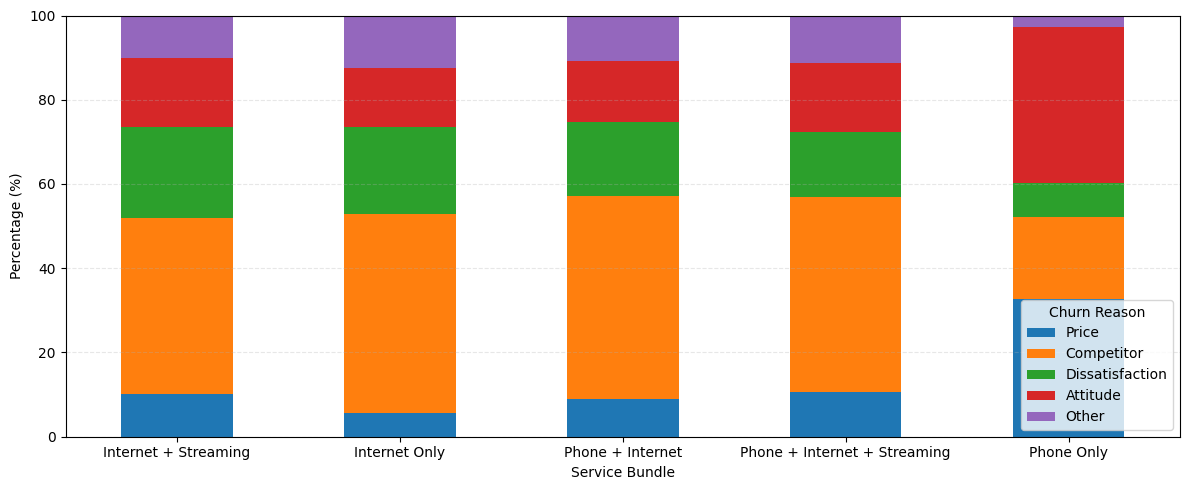

In [120]:
churn_reason_by_service = pd.DataFrame(churn_reason_by_service)

fig, ax = plt.subplots(figsize=(12, 5))

churn_reason_order = ["Price", "Competitor", "Dissatisfaction", "Attitude", "Other"]

churn_reason_by_service["churn_category"] = pd.Categorical(
    churn_reason_by_service["churn_category"], 
    categories=churn_reason_order, 
    ordered=True
)

pivot_pct = churn_reason_by_service.pivot_table(
    index="service_bundle", 
    columns="churn_category", 
    values="count", 
    aggfunc="sum", 
    fill_value=0,
    observed=False
)

pivot_pct_norm = pivot_pct.div(pivot_pct.sum(axis=1), axis=0) * 100

pivot_pct_norm.plot(kind="bar", stacked=True, ax=ax)
ax.set_xlabel("Service Bundle")
ax.set_ylabel("Percentage (%)")
ax.tick_params(axis="x", rotation=0)
ax.set_ylim(0, 100)
ax.legend(title="Churn Reason")
ax.grid(axis="y", alpha=0.3, linestyle="--")

plt.tight_layout()
plt.show()

In [183]:
%%sql
SELECT churn_category,
       ROUND(COUNT(*) / CAST((SELECT COUNT(*) FROM status WHERE churn_value = True) AS numeric), 2) AS percentage_of_churned
FROM status
WHERE churn_value = True
GROUP BY churn_category

churn_category,percentage_of_churned
Attitude,0.17
Other,0.11
Dissatisfaction,0.16
Price,0.11
Competitor,0.45


There seems to be no difference in the churn rate for different service bundles. We are seeing a different distribution of churn reasons for phone only customers but that is due to low customer count (113 out of 1869 that churned) for that type of bundle.

#### Do extra charges / refunds correlate with churn?

In [161]:
%%sql extra_charges_refunds <<
SELECT churn_value,
       total_extra_data_charges,
       total_long_dist_charges,
       total_refunds
FROM status LEFT JOIN services ON status.customer_id = services.customer_id

Returning data to local variable extra_charges_refunds


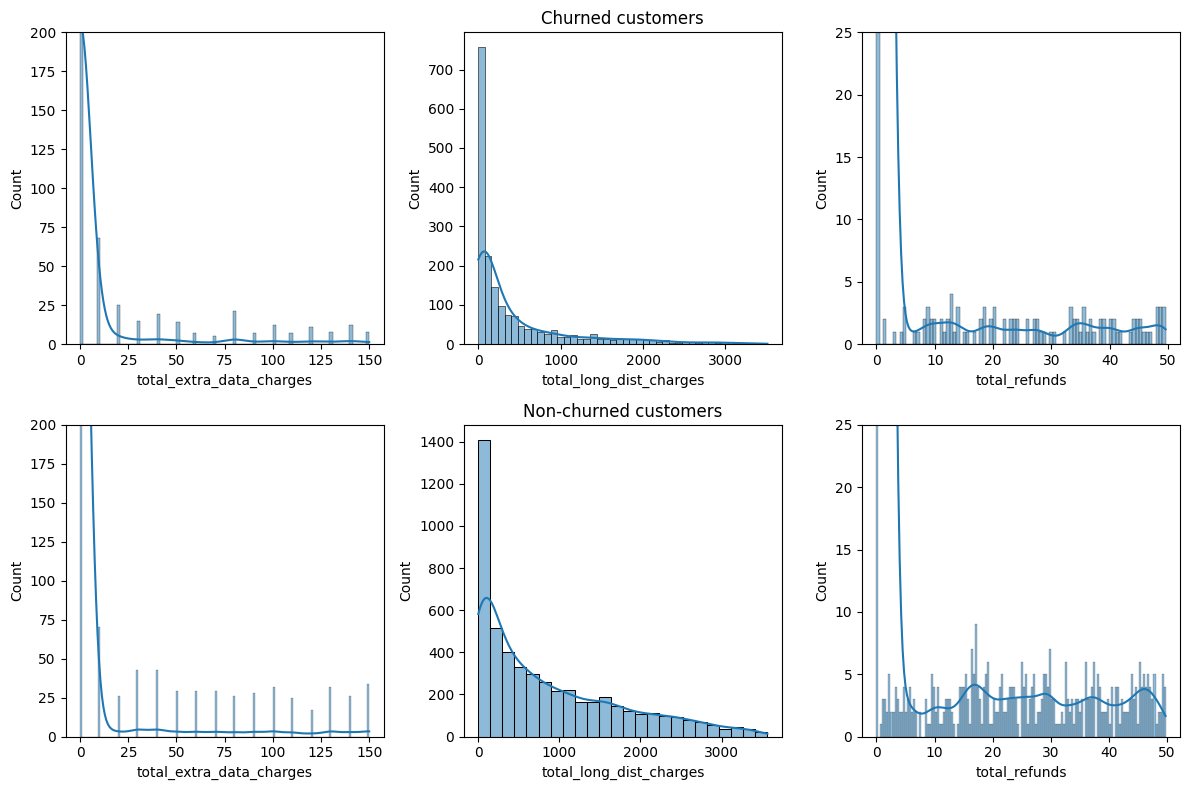

In [175]:
extra_charges_refunds = pd.DataFrame(extra_charges_refunds)

fig, axes = plt.subplots(2, 3, figsize=(12, 8))

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == True],
             x="total_extra_data_charges", kde=True, ax=axes[0, 0])
axes[0, 0].set_ylim(0, 200)

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == True], 
             x="total_long_dist_charges", kde=True, ax=axes[0, 1])
axes[0, 1].set_title("Churned customers")

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == True],
             x="total_refunds", kde=True, ax=axes[0, 2])
axes[0, 2].set_ylim(0, 25)

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == False],
             x="total_extra_data_charges", kde=True, ax=axes[1, 0])
axes[1, 0].set_ylim(0, 200)

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == False], 
             x="total_long_dist_charges", kde=True, ax=axes[1, 1])
axes[1, 1].set_title("Non-churned customers")

sns.histplot(data=extra_charges_refunds[extra_charges_refunds["churn_value"] == False],
             x="total_refunds", kde=True, ax=axes[1, 2])
axes[1, 2].set_ylim(0, 25)

plt.tight_layout()
plt.show()

We see that distributions in both cases look fairly similar.

In [182]:
%%sql
SELECT churn_value AS "Churned",
       ROUND(CAST(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_extra_data_charges) AS numeric), 2) AS "Extra Data Charge",
       ROUND(CAST(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_long_dist_charges) AS numeric), 2) AS "Long Distance Charges",
       ROUND(CAST(PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY total_refunds) AS numeric), 2) AS "Total Refunds"
FROM status LEFT JOIN services ON status.customer_id = services.customer_id
GROUP BY churn_value

Churned,Extra Data Charge,Long Distance Charges,Total Refunds
False,0.00,564.62,0.00
True,0.00,139.08,0.00


Atleast half of our clients were never charged extra for data or refunded at all. Long distance charge values for non-churned customers are larger as they have been with the company for longer.

Data shows that customers are not leaving due to being overcharged for extras but for pricier services as a whole (as we saw before).